In [1]:
import datetime
import pickle

import geopandas as gpd
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import segregation
from esda.moran import Moran, Moran_Local
from libpysal.weights.distance import DistanceBand

In [2]:
def get_urban_centers_gdf_timeline(region, month):
    column_b = f'prediction_osm_completeness_{month.year}_{str(month.month).zfill(2)}'
    gdf = gpd.read_file(
        "../data/global_urban_building_completeness.gpkg",
        layer='rf_adjusted_prediction_reference_and_osm_urban_centers_v2024',
    )
    gdf.set_geometry(gdf["geometry"].to_crs('+proj=cea').centroid.to_crs('epsg:4326'), inplace=True)
    

    gdf["osm_completeness"] = gdf[column_b]
    gdf.rename(columns={column_b: "prediction_osm_completeness"}, inplace=True)
    gdf.loc[gdf['prediction'] < 0, 'prediction'] = 0     #v2023: sum_prediction_sqkm
    gdf.loc[gdf['osm_completeness'] < 0, 'osm_completeness'] = 0
    gdf.loc[gdf['osm_completeness'] > 1, 'osm_completeness'] = 1
    gdf = gdf.loc[gdf["region_wb"].isin(region)]
    gdf["sum_osm_building_area_sqkm"] = gdf["prediction"] * gdf["osm_completeness"]
    
    print(len(gdf))
    
    all_columns = gdf.columns
    include_fields=[
        "urban_center_id", "region_wb", "ghs_pop_2023", "prediction",
        "prediction_osm_completeness", "sum_osm_building_area_sqkm", "osm_completeness",
        "geometry"
    ]
    columns_to_drop = list(set(all_columns) - set(include_fields))    
    gdf.drop(
        columns_to_drop,
        axis=1,
        inplace=True
    )
    
    gdf.dropna(inplace=True)
    print(len(gdf))
    
    print(f"got {len(gdf)} samples")
    return gdf

## Configuration and Styles

In [3]:
model_name = "rf_adjusted"
training_data = "reference_and_osm"

wb_regions = [
    ["East Asia & Pacific"],
    ["Europe & Central Asia"],
    ["Latin America & Caribbean"],
    ["Middle East & North Africa"],
    ["North America"],
    ["South Asia"],
    ["Sub-Saharan Africa"],
    [
        "Europe & Central Asia", 
        "Latin America & Caribbean", 
        "North America", 
        "East Asia & Pacific", 
        "South Asia", 
        "Middle East & North Africa",
        "Sub-Saharan Africa"
    ],
]

linestyles = [
    ('dotted',                (0, (1, 1))),
    ('densely dashed',        (0, (5, 1))),
    ('densely dashed',        (0, (5, 1))),
    ('solid',                 (0, ())),
    ('dotted',                (0, (1, 1))),
    ('solid',                 (0, ())),
    ('densely dashed',        (0, (5, 1))),
    ('solid',                 (0, ())),
]

label_strings = [
    "East Asia & Pacific",
    "Europe & Central Asia",
    "Latin America & Caribbean",
    "Middle East & North Africa",
    "North America",
    "South Asia",
    "Sub-Saharan Africa",
    "all"
]

cmap = matplotlib.cm.get_cmap('tab10')
colors_dict = {
    "East Asia & Pacific": cmap(0),
    "Europe & Central Asia": cmap(0.125),
    "Latin America & Caribbean": cmap(0.25),
    "Middle East & North Africa": cmap(0.375),
    "North America": cmap(0.5),
    "South Asia": cmap(0.625),
    "Sub-Saharan Africa": cmap(0.75),
    "all": "black",
}


all_months = [
    datetime.date(2008, 1, 1),
    datetime.date(2009, 1, 1),
    datetime.date(2010, 1, 1),
    datetime.date(2011, 1, 1),
    datetime.date(2012, 1, 1),
    datetime.date(2013, 1, 1),
    datetime.date(2014, 1, 1),
    datetime.date(2015, 1, 1),
    datetime.date(2016, 1, 1),
    datetime.date(2017, 1, 1),
    datetime.date(2018, 1, 1),
    datetime.date(2019, 1, 1),
    datetime.date(2020, 1, 1),
    datetime.date(2021, 1, 1),
    datetime.date(2022, 1, 1),
    datetime.date(2023, 1, 1),
    datetime.date(2024, 1, 1),
    datetime.date(2024, 5, 1)
]

outfile = "../data/inequality_stats_data_v2024.pkl"

/tmp/ipykernel_18691/3302344990.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('tab10')


## Calculate Moran's I and Gini Coefficient
this takes around 15 minutes.

In [4]:
morans_lists = {}
gini_lists = {}
pop_low_completeness_lists = {}
pop_high_completeness_lists = {}
avg_completeness_lists = {}

for i, region in enumerate(wb_regions):
    
    morans_lists[i] = []
    gini_lists[i] = []
    pop_low_completeness_lists[i] = []
    pop_high_completeness_lists[i] = []
    avg_completeness_lists[i] = []
    
    for j, month in enumerate(all_months):
        print(month)
        
        df = get_urban_centers_gdf_timeline(
            region,
            month,
        ).reset_index()
        
        avg_completeness_lists[i].append(
            df["prediction_osm_completeness"].mean()
        )
        
        index = segregation.singlegroup.gini.Gini(
            df[['sum_osm_building_area_sqkm', 'prediction']],
            'sum_osm_building_area_sqkm',
            'prediction'
        )
        gini_lists[i].append(index.statistic)

        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        df = df.loc[~df.index.isin(w.islands)]

        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        y = df['osm_completeness']
        # global and local Moran's I
        try:
            moran_global = Moran(y, w)
            moran_loc = Moran_Local(y, w)
            df[f"{month.year}_moran_loc"] = moran_loc.Is
            df[f"{month.year}_moran_loc_q"] = moran_loc.q
            df[f"{month.year}_moran_loc_p_sim"] = moran_loc.p_sim
            df[f"{month.year}_moran_global"] = moran_global.I
        except (ZeroDivisionError, StopIteration):
            df[f"{month.year}_moran_loc"] = np.nan
            df[f"{month.year}_moran_global"] = np.nan

        morans_lists[i].append(moran_global.I)

        pop_low_completeness = df.loc[df['osm_completeness'] < 0.2]["ghs_pop_2023"].sum() / df["ghs_pop_2023"].sum()
        pop_low_completeness_lists[i].append(pop_low_completeness)

        pop_high_completeness = df.loc[df['osm_completeness'] >= 0.8]["ghs_pop_2023"].sum() / df["ghs_pop_2023"].sum()
        pop_high_completeness_lists[i].append(pop_high_completeness)

2008-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2009-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2010-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2011-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2012-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2013-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2014-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2015-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2016-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2017-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2018-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2019-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2020-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2021-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2022-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2023-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2024-01-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2024-05-01
3222
3222
got 3222 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
 There are 6 islands with ids: 0, 1, 2, 23, 90, 701.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 90, ' is an island (no neighbors)')
('WARNING: ', 701, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  W.__init__(


2008-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2009-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2010-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2011-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2012-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2013-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2014-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2015-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2016-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2017-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2018-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2019-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2020-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2021-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2022-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2023-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2024-01-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2024-05-01
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


2008-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2009-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2010-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2011-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2012-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2013-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2014-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2015-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2016-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2017-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2018-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2019-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2020-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2021-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2022-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2023-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2024-01-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2024-05-01
1091
1091
got 1091 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(


2008-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2009-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2010-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2011-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2012-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2013-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2014-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2015-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2016-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2017-01-01
1001
1001
got 1001 samples
('WARNING: ', 683, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


2018-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2019-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2020-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2021-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2022-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2023-01-01
1001
1001
got 1001 samples
('WARNING: ', 683, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


2024-01-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2024-05-01
1001
1001
got 1001 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 683.
  W.__init__(


('WARNING: ', 683, ' is an island (no neighbors)')
2008-01-01
398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2009-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2010-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2011-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2012-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2013-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2014-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

2015-01-01
398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2016-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2017-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2018-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2019-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2020-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2021-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2022-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2023-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

2024-01-01
398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2024-05-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

398
398
got 398 samples
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 105, ' is an island (no neighbors)')
('WARNING: ', 107, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 201, ' is an island (no neighbors)')
2008-01-01


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 23, 105, 107, 140, 201.
  W.__init__(
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.

2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2009-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2010-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2011-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2012-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2013-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2014-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2015-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2016-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2017-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2018-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2019-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2020-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2021-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2022-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2023-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2024-01-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2024-05-01
2619
2619
got 2619 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 3, 2618.
  W.__init__(


('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 2618, ' is an island (no neighbors)')
2008-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2009-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2010-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2011-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2012-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2013-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2014-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2015-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2016-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2017-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2018-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2019-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2020-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2021-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2022-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2023-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2024-01-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2024-05-01
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


2008-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2009-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2010-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2011-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2012-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2013-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2014-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2015-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2016-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2017-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2018-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2019-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2020-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2021-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2022-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2023-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2024-01-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


2024-05-01
11686
11686
got 11686 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 19 islands with ids: 0, 1, 3, 47, 164, 188, 277, 780, 1075, 1465, 4054, 4097, 4511, 5243, 6456, 6567, 7607, 7632, 7705.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 188, ' is an island (no neighbors)')
('WARNING: ', 277, ' is an island (no neighbors)')
('WARNING: ', 780, ' is an island (no neighbors)')
('WARNING: ', 1075, ' is an island (no neighbors)')
('WARNING: ', 1465, ' is an island (no neighbors)')
('WARNING: ', 4054, ' is an island (no neighbors)')
('WARNING: ', 4097, ' is an island (no neighbors)')
('WARNING: ', 4511, ' is an island (no neighbors)')
('WARNING: ', 5243, ' is an island (no neighbors)')
('WARNING: ', 6456, ' is an island (no neighbors)')
('WARNING: ', 6567, ' is an island (no neighbors)')
('WARNING: ', 7607, ' is an island (no neighbors)')
('WARNING: ', 7632, ' is an island (no neighbors)')
('WARNING: ', 7705, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  W.__init__(


## Save Results


In [5]:
stats = []
for i, region in enumerate(wb_regions):
    stats.append([
        label_strings[i],
        all_months,
        avg_completeness_lists[i],
        pop_low_completeness_lists[i],
        pop_high_completeness_lists[i],
        morans_lists[i],
        gini_lists[i]
    ])
    
with open(outfile, 'wb') as f:
    pickle.dump(stats, f)

## Create Plots

In [6]:
with open(outfile, 'rb') as f:
    stats_new = pickle.load(f)

columns = [
    "region",
    "months",
    "avg_completeness",
    "pop_low_completeness",
    "pop_high_completeness",
    "morans",
    "gini"
]    
    
stats_df = pd.DataFrame(
    stats_new,
    columns=columns
)
display(stats_df)

display(
    stats_df.loc[stats_df["region"] == 'all']["morans"].values
)

,region,months,avg_completeness,pop_low_completeness,pop_high_completeness,morans,gini
0,East Asia & Pacific,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[1.9694361811543303e-05, 0.0001942511132528065...","[1.0, 1.0, 1.0, 0.9999353426256288, 0.99541346...","[0.0, 0.0, 0.0, 0.0, 0.0, 8.666049786105551e-0...","[0.02865981902532822, 0.042327322809579314, 0....","[0.966440769337867, 0.9244522606160571, 0.9064..."
1,Europe & Central Asia,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[0.0009213781424904145, 0.013263015649545181, ...","[1.0, 0.9860139642351973, 0.8684349649329557, ...","[0.0, 0.0025032104361476593, 0.006247882258259...","[0.10117903035759326, 0.084015426563279, 0.214...","[0.8982027847774807, 0.8251734761969722, 0.780..."
2,Latin America & Caribbean,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[3.343413940939291e-06, 9.017563172502203e-05,...","[1.0, 1.0, 1.0, 0.9966297071800824, 0.99144867...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001819309178...","[-0.0009309929968889493, -0.005593111689079903...","[0.9742205247405482, 0.8777958249296828, 0.797..."
3,Middle East & North Africa,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[8.556386595169945e-06, 0.00024993828638862284...","[1.0, 1.0, 1.0, 0.9997929498205909, 0.99848439...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004789471291...","[-0.00015696101816057065, 0.05673521936223217,...","[0.9433086421655241, 0.9180080674607398, 0.851..."
4,North America,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[0.000334832420252607, 0.003954016996779672, 0...","[1.0, 1.0, 0.9869198685245462, 0.9051769617770...","[0.0, 0.0, 0.0, 0.0021480378218865733, 0.00214...","[0.08903471029933355, 0.07185859192882238, 0.1...","[0.9584086126854428, 0.724654751592134, 0.7405..."
5,South Asia,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[6.837200479282085e-05, 8.544428177481021e-05,...","[1.0, 1.0, 1.0, 1.0, 0.9991065419785996, 0.998...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00018588048755383517, 0.0003379371053987339...","[0.9999045103937354, 0.9344727847676942, 0.885..."
6,Sub-Saharan Africa,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[2.4506194804758693e-06, 2.316923432885294e-05...","[1.0, 1.0, 1.0, 1.0, 0.9983907094662199, 0.981...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.000128162933020270...","[-0.0012551035106919363, 0.0008628787241143927...","[0.9804669444998946, 0.9043287666564832, 0.886..."
7,all,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[0.00015366642743985887, 0.0019693601862075865...","[1.0, 0.998527363653567, 0.9855984192519449, 0...","[0.0, 0.00026357137455050524, 0.00065786035846...","[0.06240354678833991, 0.11803872285924395, 0.2...","[0.9737838481384851, 0.9376554724179601, 0.922..."


array([list([np.float64(0.06240354678833991), np.float64(0.11803872285924395), np.float64(0.29321568645412643), np.float64(0.5094508552295408), np.float64(0.6400306676165602), np.float64(0.7024054020149004), np.float64(0.7129968977119521), np.float64(0.703858708310704), np.float64(0.6908243018547316), np.float64(0.6595612810104411), np.float64(0.6236617863226528), np.float64(0.5945185451878323), np.float64(0.6024965586379626), np.float64(0.5953010338766234), np.float64(0.5905885257971435), np.float64(0.5756818757231393), np.float64(0.5732766701314629), np.float64(0.5714823466977189)])],
      dtype=object)

/tmp/ipykernel_18691/3529118833.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('tab10')


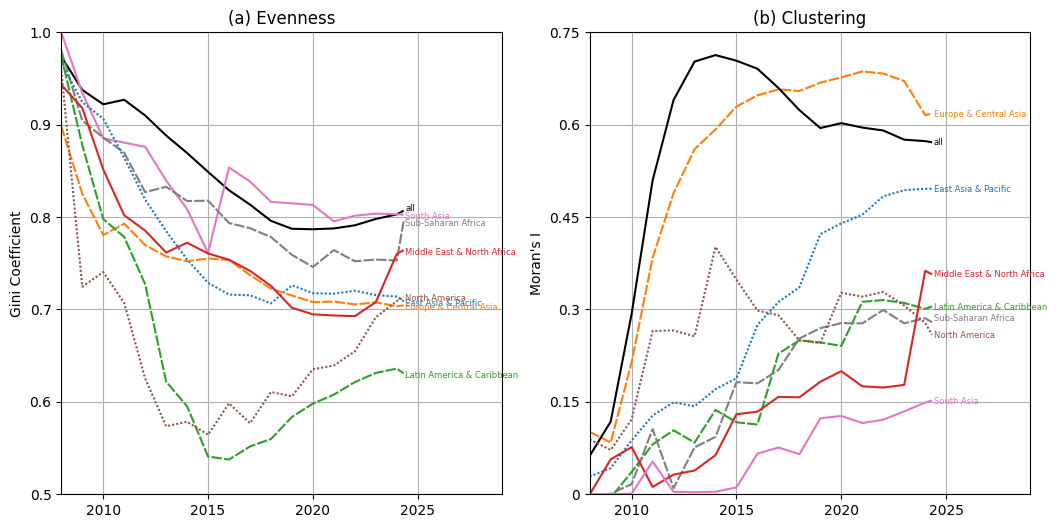

In [7]:
fontsize = 6

#fig, axs = plt.subplots(1, 2, figsize=(12.5, 6)) # using this approach, as has been in the original notebook, leads to doubled x-axis labels, the ones specified and additional from 0 to 1 
fig = plt.figure(figsize=(12.5, 6))
gs1 = gridspec.GridSpec(1, 2, fig)
gs1.update(wspace=0.2, hspace=0.2) # set the spacing between axes.

max_y_values = {
    "gini": [],
    "morans": []
}

columns = [
    "gini",
    "morans"
]


cmap = matplotlib.cm.get_cmap('tab10')
colors_dict = {
    "East Asia & Pacific": cmap(0),
    "Europe & Central Asia": cmap(0.125),
    "Latin America & Caribbean": cmap(0.25),
    "Middle East & North Africa": cmap(0.375),
    "North America": cmap(0.5),
    "South Asia": cmap(0.625),
    "Sub-Saharan Africa": cmap(0.75),
    "all": "black",
}

linestyles_dict = {
    "East Asia & Pacific": ('dotted', (0, (1, 1))),
    "Europe & Central Asia": ('densely dashed', (0, (5, 1))),
    "Latin America & Caribbean": ('densely dashed', (0, (5, 1))),
    "Middle East & North Africa": ('solid', (0, ())),
    "North America": ('dotted', (0, (1, 1))),
    "South Asia": ('solid',(0, ())),
    "Sub-Saharan Africa": ('densely dashed', (0, (5, 1))),
    "all":  ('solid', (0, ())),
}
    

label_strings_new = {
    "gini": [
        "all",
        "South Asia",
        "Sub-Saharan Africa",
        "East Asia & Pacific",
        "Europe & Central Asia",
        "Latin America & Caribbean",
        "Middle East & North Africa",
        "North America",
    ],
    "morans": [
        "Europe & Central Asia",
        "all",
        "East Asia & Pacific",
        "Latin America & Caribbean",
        "Sub-Saharan Africa",
        "North America",
        "Middle East & North Africa",
        "South Asia",
    ]
}

for j, column in enumerate(columns):
    ax = plt.subplot(gs1[j])
    
    for i, region in enumerate(label_strings_new[column]):
        region_df = stats_df.loc[stats_df["region"] == region]

        max_y_values[column].append(
            region_df[column].to_list()[0][-1]
        )

        ax.plot(
            region_df["months"].to_list()[0],
            region_df[column].to_list()[0],
            label=region,
            color=colors_dict[region],
            linestyle=linestyles_dict[region][1]
        )

        if region == 'all' and column == 'gini':
            label_position = max_y_values[column][i] + 0.005
        elif region == 'Sub-Saharan Africa' and column == 'morans':
            label_position = max_y_values[column][i] + 0.0075
        else:
            label_position = max_y_values[column][i]

        ax.annotate(
            region,
            (datetime.date(2024, 6, 1), label_position - 0.005),
            fontsize=fontsize,
            color=colors_dict[region]
        )
    
ax = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])  

ax.set_title("(a) Evenness")
ax.set_ylabel("Gini Coefficient")
ax.set_xlim([datetime.date(2008, 1, 1), datetime.date(2029, 1, 1)])
ax.set_ylim([0.5,1.0])
ax.set_xticks([
    datetime.date(2010, 1, 1),
    datetime.date(2015, 1, 1),
    datetime.date(2020, 1, 1),
    datetime.date(2025, 1, 1),
])
ax.set_xticklabels(["2010", "2015", "2020", "2025"])
ax.grid()

ax1.set_title("(b) Clustering")
ax1.set_ylabel("Moran's I")
ax1.set_xlim([datetime.date(2008, 1, 1), datetime.date(2029, 1, 1)])
ax1.grid()
ax1.set_xticks([
    datetime.date(2010, 1, 1),
    datetime.date(2015, 1, 1),
    datetime.date(2020, 1, 1),
    datetime.date(2025, 1, 1),
])
ax1.set_xticklabels(["2010", "2015", "2020", "2025"])
ax1.set_yticks([
    0, 0.15, 0.30, 0.45, 0.6, 0.75
])
ax1.set_yticklabels([0, 0.15, 0.30, 0.45, 0.6, 0.75])
ax1.set_ylim([0,0.75])


plt.savefig(
    f"../data/figures/inequality/completeness_inequality_per_month_by_region_{model_name}_v2024.pdf",
    dpi=300,
    bbox_inches = 'tight',
    pad_inches = 0.25
)

plt.show()  

## Get Data for Europe & Central Asia and Sub-Saharan Africa

In [8]:
display(df)

,index,urban_center_id,ghs_pop_2023,prediction,prediction_osm_completeness,region_wb,geometry,osm_completeness,sum_osm_building_area_sqkm,2024_moran_loc,2024_moran_loc_q,2024_moran_loc_p_sim,2024_moran_global
2,2,3,53721,1.831028,0.079047,North America,POINT (-158.01694 21.3244),0.079047,0.144737,-0.220039,2,0.316,0.571482
4,4,5,76707,3.425973,0.172562,Latin America & Caribbean,POINT (-117.05451 32.37649),0.172562,0.591192,-0.247972,2,0.015,0.571482
5,5,6,250762,12.137755,0.776040,North America,POINT (-123.35334 48.44708),0.776040,9.419380,2.569760,1,0.001,0.571482
6,6,7,62528,0.851833,0.009217,Latin America & Caribbean,POINT (-92.05613 14.91044),0.009217,0.007851,-0.174121,2,0.112,0.571482
7,7,8,83850,2.145722,0.160665,Latin America & Caribbean,POINT (-89.84755 13.93222),0.160665,0.344742,-0.029246,2,0.300,0.571482
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,11681,11682,252067,7.137708,0.041780,East Asia & Pacific,POINT (121.25594 28.11263),0.041780,0.298212,0.415999,3,0.001,0.571482
11682,11682,11683,54242,1.916450,0.012559,East Asia & Pacific,POINT (121.15191 27.83963),0.012559,0.024069,0.460339,3,0.001,0.571482
11683,11683,11684,80162,3.137552,0.002044,East Asia & Pacific,POINT (121.59331 28.34725),0.002044,0.006413,0.482137,3,0.001,0.571482
11684,11684,11685,73418,2.516636,0.006967,East Asia & Pacific,POINT (121.59557 28.27314),0.006967,0.017533,0.474382,3,0.001,0.571482


In [9]:
wb_regions = [
    ["East Asia & Pacific"],
    ["Europe & Central Asia"],
    ["Latin America & Caribbean"],
    ["Middle East & North Africa"],
    ["North America"],
    ["South Asia"],
    ["Sub-Saharan Africa"],
    [
        "Europe & Central Asia", 
        "Latin America & Caribbean", 
        "North America", 
        "East Asia & Pacific", 
        "South Asia", 
        "Middle East & North Africa",
        "Sub-Saharan Africa"
    ],
]


all_months = [
    datetime.date(2010, 1, 1),
    datetime.date(2014, 1, 1),
    datetime.date(2024, 5, 1),
]

colors = [
    "blue",
    "green",
    "yellow",
    "violet"
]

column = "osm_completeness"

for j, region_id in enumerate([1, 6]):
    region = wb_regions[region_id]
    
    for i, month in enumerate(all_months):
        
        # need to make sure to reset index!
        df = get_urban_centers_gdf_timeline(
            region,
            month
        )
        df.drop(["prediction_osm_completeness"], axis=1, inplace=True)
        
        index = segregation.singlegroup.gini.Gini(
            df[['sum_osm_building_area_sqkm', 'prediction']],
            'sum_osm_building_area_sqkm',
            'prediction'
        )
        gini = index.statistic
        
        df.reset_index(inplace=True)
        
        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        df = df.loc[~df.index.isin(w.islands)]
        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        y = df[column]
        # global and local Moran's I
        try:
            moran_global = Moran(y, w)
            moran_loc = Moran_Local(y, w)
            df[f"{column}_moran_loc"] = moran_loc.Is
            df[f"{column}_moran_loc_q"] = moran_loc.q
            df[f"{column}_moran_loc_p_sim"] = moran_loc.p_sim
            df[f"{column}_moran_global"] = moran_global.I
        except (ZeroDivisionError, StopIteration):
            df[f"{column}_moran_loc"] = np.nan
            df[f"{column}_moran_global"] = np.nan

        morans = moran_global.I

        print(region, month, gini, morans)

        df["alpha"] = 0.2
        df.loc[df["osm_completeness_moran_loc_p_sim"] < 0.1, "alpha"] = 1
        df.to_file(
            "../data/global_urban_building_completeness.gpkg",
            layer=f'{region[0]}_{month}_v2024',
            driver="GPKG"
        )

1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


['Europe & Central Asia'] 2010-01-01 0.7805083973239206 0.21465167701054247
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


['Europe & Central Asia'] 2014-01-01 0.7521989594122921 0.5923393307997448
1523
1523
got 1523 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 13 islands with ids: 0, 1, 4, 50, 84, 302, 1405, 1510, 1511, 1512, 1513, 1521, 1522.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 302, ' is an island (no neighbors)')
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1510, ' is an island (no neighbors)')
('WARNING: ', 1511, ' is an island (no neighbors)')
('WARNING: ', 1512, ' is an island (no neighbors)')
('WARNING: ', 1513, ' is an island (no neighbors)')
('WARNING: ', 1521, ' is an island (no neighbors)')
('WARNING: ', 1522, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(


['Europe & Central Asia'] 2024-05-01 0.7044239781319104 0.6179811954263539
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


['Sub-Saharan Africa'] 2010-01-01 0.8860920811760364 0.016500433497158257
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


['Sub-Saharan Africa'] 2014-01-01 0.8173914791558399 0.09312583347707493
1832
1832
got 1832 samples


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 46.
  W.__init__(


('WARNING: ', 46, ' is an island (no neighbors)')


/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/briochamsley/.cache/pypoetry/virtualenvs/oqapi-analysis-QKiHp62D-py3.12/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


['Sub-Saharan Africa'] 2024-05-01 0.7956730300085217 0.27906867583298645
